<a href="https://colab.research.google.com/github/vi14m/Sign_Language_Recognition_DeepLearning/blob/main/Sign_Language_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ls

sample_data  sign_mnist_test.csv  sign_mnist_train.csv


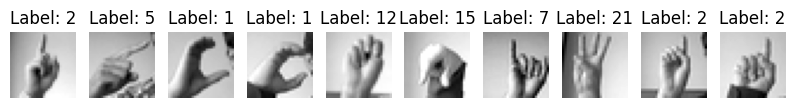

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Load data from CSV
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

# Extract labels and pixel values
y_train = train_df['label'].values
X_train = train_df.drop('label', axis=1).values
y_test = test_df['label'].values
X_test = test_df.drop('label', axis=1).values

# Reshape pixel values to images
IMG_SIZE = (28, 28)  # Assuming images are 28x28
X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Handle NaNs
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

y_train = y_train - 1
y_test = y_test - 1

# Convert labels to categorical (one-hot encoding)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=24)  # Assuming 24 classes
y_test = tf.keras.utils.to_categorical(y_test, num_classes=24)

# Verify no NaNs in data
assert not np.isnan(X_train).any(), "NaNs still found in training data!"
assert not np.isnan(y_train).any(), "NaNs still found in training labels!"

# Visualize a few samples from the dataset
def plot_samples(X, y, num_samples=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i].reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
        plt.title(f'Label: {y[i]}')
        plt.axis('off')
    plt.show()

plot_samples(X_train, np.argmax(y_train, axis=1))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(24, activation='softmax')  # 24 classes
])

# Compile the model
optimizer = Adam(learning_rate=1e-4)  # Lowered learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('gesture_recognition_model.h5', save_best_only=True, monitor='val_loss')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Ensure no NaNs in data
assert not np.isnan(X_train).any(), "NaNs found in training data!"
assert not np.isnan(y_train).any(), "NaNs found in training labels!"

# Train the model
model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Optionally save the model after training is complete
model.save('gesture_recognition_model_final.h5')

Epoch 1/30
227/227 [==============================] - 6s 19ms/step - loss: 3.1600 - accuracy: 0.1371 - val_loss: 3.2544 - val_accuracy: 0.0291
Epoch 2/30
227/227 [==============================] - 4s 19ms/step - loss: 2.4286 - accuracy: 0.2731 - val_loss: 2.5229 - val_accuracy: 0.3009
Epoch 3/30
227/227 [==============================] - 4s 19ms/step - loss: 2.0610 - accuracy: 0.3817 - val_loss: 1.6003 - val_accuracy: 0.5432
Epoch 4/30
227/227 [==============================] - 4s 19ms/step - loss: 1.7342 - accuracy: 0.4667 - val_loss: 1.1774 - val_accuracy: 0.6570
Epoch 5/30
227/227 [==============================] - 4s 19ms/step - loss: 1.5185 - accuracy: 0.5184 - val_loss: 0.9571 - val_accuracy: 0.6994
Epoch 6/30
227/227 [==============================] - 4s 19ms/step - loss: 1.3533 - accuracy: 0.5655 - val_loss: 0.7867 - val_accuracy: 0.7673
Epoch 7/30
227/227 [==============================] - 4s 19ms/step - loss: 1.1983 - accuracy: 0.6186 - val_loss: 0.7009 - val_accuracy: 0.7731

1/1 [==============================] - 0s 107ms/step


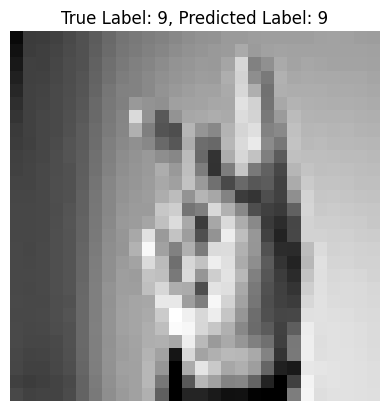

In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
loaded_model = load_model('gesture_recognition_model.h5')

# Choose a random test sample
random_index = np.random.randint(0, X_test.shape[0])
sample_image = X_test[random_index]
true_label = np.argmax(y_test[random_index])

# Make a prediction
prediction = loaded_model.predict(np.expand_dims(sample_image, axis=0))
predicted_label = np.argmax(prediction)

# Display the result
plt.imshow(sample_image.reshape(IMG_SIZE[0], IMG_SIZE[1]), cmap='gray')
plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
plt.axis('off')
plt.show()
